In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white', font_scale=1.5, rc = {'figure.figsize':(12,6)})

# Data directory
data_dir = Path() / 'data'

# Create dict of dataframes from data_dir
df_dict = {}
for file in data_dir.glob('*.csv'):
    # Semicolon delimited, and skip two lines for simplicity
    df_dict[file.stem] = pd.read_csv(file, sep=';', skiprows=2)

In [36]:
GBP = df_dict.get('historical_GBP')
EUR = df_dict.get('historical_EUR')
USD = df_dict.get('historical_USD')
CHF = df_dict.get('historical_CHF')
markets = [GBP, EUR, USD, CHF]
markets_names = ['GBP', 'EUR', 'USD', 'CHF']
# concat dataframes and add name of symbol
master = pd.concat([GBP, EUR, USD, CHF], axis=1, keys=['GBP', 'EUR', 'USD', 'CHF'])

In [37]:
master[0:30]

GBP                         EUR                         USD  \
           Date   Price Volume         Date   Price Volume         Date   
0    24.03.2022  11.472      4   24.03.2022  13.734    301   24.03.2022   
1    23.03.2022  11.196      6   23.03.2022  13.620      0   23.03.2022   
2    22.03.2022  11.450      9   22.03.2022  13.530    500   22.03.2022   
3    21.03.2022  11.052      2   21.03.2022  13.180   1890   21.03.2022   
4    18.03.2022  11.024      0   18.03.2022  13.132      0   18.03.2022   
5    17.03.2022  10.984      4   17.03.2022  12.938      0   17.03.2022   
6    16.03.2022  10.954   4119   16.03.2022  13.018   7936   16.03.2022   
7    15.03.2022  10.392      2   15.03.2022  12.372      7   15.03.2022   
8    14.03.2022  10.496      0   14.03.2022  12.626   4601   14.03.2022   
9    11.03.2022  10.422      0   11.03.2022  12.546    139   11.03.2022   
10   10.03.2022  10.434   1072   10.03.2022  12.506    648   10.03.2022   
11   09.03.2022  11.336      0   09.03.2022  13.572    262   09.03.2022   
12   08.03.2022  10.318      0   08.03.2022  12.528    538   08.03.2022   
13   07.03.2022  10.566      0   07.03.2022  12.420    320   07.03.2022   
14   04.03.2022  10.846      0   04.03.2022  13.230  11890   04.03.2022   
15   03.03.2022  11.206   3079   03.03.2022  13.606   1322   03.03.2022   
16   02.03.2022  11.792    826   02.03.2022  14.060   1403   02.03.2022   
17   01.03.2022  11.564   5959   01.03.2022  13.896   3047   01.03.2022   
18   28.02.2022  10.172    816   28.02.2022  12.924   1523   28.02.2022   
19   25.02.2022  10.106   4899   25.02.2022  12.194    425   25.02.2022   
20   24.02.2022   9.419  10106   24.02.2022  11.276  17571   24.02.2022   
21   23.02.2022  10.020   4709   23.02.2022  12.020   4609   23.02.2022   
22   22.02.2022   9.776      0   22.02.2022  11.504    400   22.02.2022   
23   21.02.2022  10.104   1000   21.02.2022  11.892    881   21.02.2022   
24   18.02.2022  10.300     95   18.02.2022  12.490   2143   18.02.2022   
25   17.02.2022  10.978    816   17.02.2022  13.074   1264   17.02.2022   
26   16.02.2022  11.316      0   16.02.2022  13.476  11275   16.02.2022   
27   15.02.2022  11.482      0   15.02.2022  13.750    981   15.02.2022   
28   14.02.2022  11.170      0   14.02.2022  13.270      2   14.02.2022   
29   11.02.2022  11.310      0   11.02.2022  13.486      0   11.02.2022   

                            CHF                 
     Price  Volume         Date   Price Volume  
0   15.422   30184   24.03.2022  14.350   2664  
1   15.080   73138   23.03.2022  13.942   1375  
2   14.990   49741   22.03.2022  14.000   3812  
3   14.500   68929   21.03.2022  13.502   1146  
4   14.526   29049   18.03.2022  13.370   2530  
5   14.350   55561   17.03.2022  13.488   4080  
6   14.208   88114   16.03.2022  13.434   5787  
7   13.704   36793   15.03.2022  12.820    475  
8   13.700    8221   14.03.2022  12.860   3844  
9   13.856   55383   11.03.2022  12.840   1440  
10  13.778   26094   10.03.2022  12.790  15945  
11  15.000  371713   09.03.2022  13.798   5391  
12  13.508   20505   08.03.2022  12.702   5895  
13  13.900   29553   07.03.2022  12.842   8926  
14  14.320   44534   04.03.2022  13.188   3561  
15  15.010   62495   03.03.2022  13.716   5778  
16  15.646   28034   02.03.2022  14.536  12567  
17  15.334   95879   01.03.2022  14.166  12489  
18  14.496  105703   28.02.2022  13.200   2097  
19  13.924   71307   25.02.2022  12.856  12280  
20  12.664  156301   24.02.2022  11.744  20390  
21  13.522   47637   23.02.2022  12.470   8375  
22  13.292   93023   22.02.2022  12.230   6004  
23  13.750   69796   21.02.2022  12.568  11387  
24  14.132  313311   18.02.2022  13.012   3580  
25  14.822   18716   17.02.2022  13.582   7110  
26  15.378   11731   16.02.2022  14.134   3550  
27  15.542  211889   15.02.2022  14.498   6300  
28  15.094  182183   14.02.2022  13.858   2035  
29  15.374   52163   11.02.2022  14.224   4187

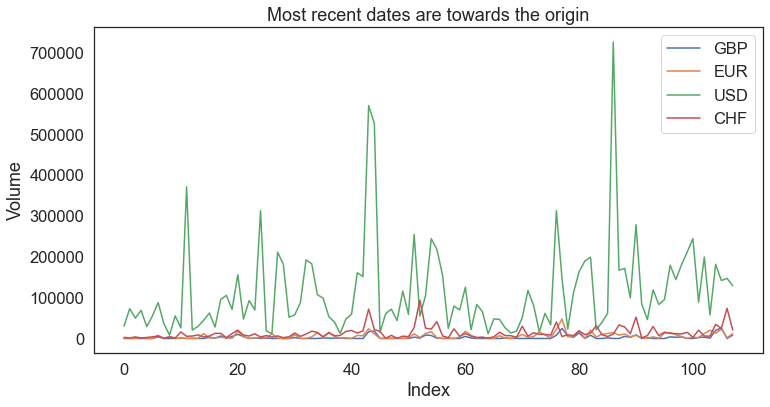

In [38]:
for i, v in enumerate(markets):
    # Plot volume of each pair
    
    plot = sns.lineplot(x=v.index, y=v['Volume'], label = markets_names[i])
    plot.set_xlabel('Index')
    plot.set_ylabel('Volume')
    plot.set_title('Most recent dates are towards the origin')

# from functions import sns_lineplot
# sns_lineplot(markets, markets_names)


C:\Users\S\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\S\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


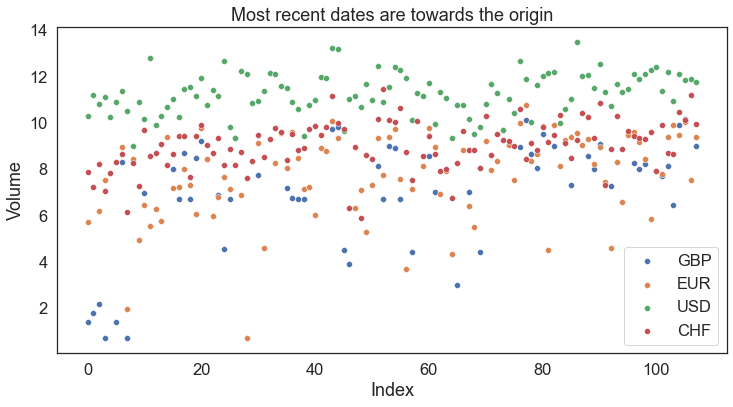

In [39]:
for i, v in enumerate(markets):
    # Plot volume of each pair with seaborn
    plot = sns.scatterplot(x=v.index, y=np.log(v['Volume']), label = markets_names[i])
    plot.set_xlabel('Index')
    plot.set_ylabel('Log Volume')
    plot.set_title('Most recent dates are towards the origin')


#### Let's manipulate the original data so that the log plot of volume correctly shows zero days where they actually are.

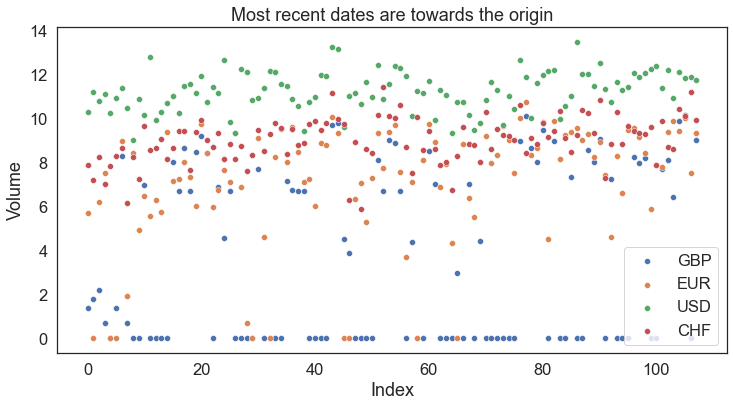

In [40]:
for df in markets:
    # replace 0 with 1
    df['Volume'] = df['Volume'].replace(0, 1)

for i, v in enumerate(markets):
    # Plot volume of each pair with seaborn
    plot = sns.scatterplot(x=v.index, y=np.log(v['Volume']), label = markets_names[i])
    plot.set_xlabel('Index')
    plot.set_ylabel('Volume')
    plot.set_title('Most recent dates are towards the origin')

In [41]:
# Are the volumes correlated?
# plot correlation matrix
volume_only = pd.DataFrame()
for i, v in enumerate(markets):
    volume_only[markets_names[i]] = v['Volume']

<AxesSubplot:>

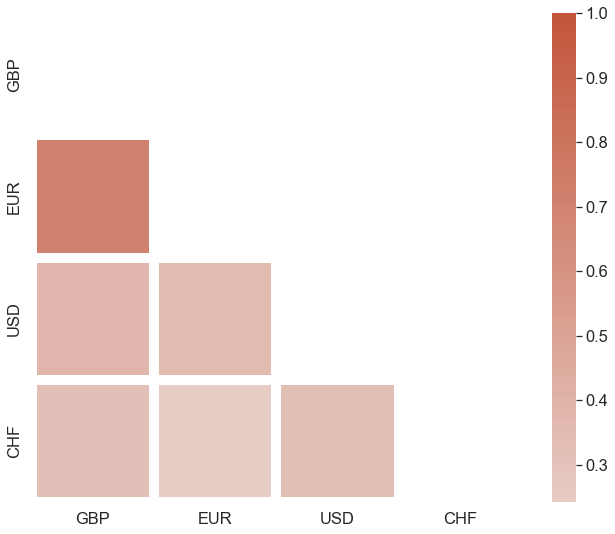

In [42]:
# plot correlation matrix
corr = volume_only.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(100, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=10)

In [55]:
# Check correlation values
corr

,GBP,EUR,USD,CHF
GBP,1.000000,0.705653,0.381363,0.314621
EUR,0.705653,1.000000,0.347160,0.242033
USD,0.381363,0.347160,1.000000,0.336213
CHF,0.314621,0.242033,0.336213,1.000000


 What about turover (volume * price) instead of only looking at share volume?
 
 Recall, though, that we are essentially comparing the same underlying across multiple markets, so one share is one share is one share.

 We could look at exchange rates at a minimum to see where there is more investigation warranted.

 I am confident that there are periodic arbitrage opportunities here, but that is well outside of the scope of this presentation.
